# PREDICT SALES OF THE ROSSMAN STORES

This project aims to predict the sales of the Rossman Stores for next 6 weeks.

# 0 - IMPORTS

In [1]:
import datetime
import inflection
import math
import pickle

import random                     as rdm
import pandas                     as pd
import numpy                      as np
import seaborn                    as sns
import xgboost                    as xgb

from IPython.display              import Image
from boruta                       import BorutaPy

from matplotlib.gridspec          import GridSpec
from matplotlib                   import pyplot          as plt

from scipy                        import stats           as ss

from sklearn.preprocessing        import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble             import RandomForestRegressor
from sklearn.metrics              import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model         import LinearRegression, Lasso

## 0.1 - Helper functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt( mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str),}, index=[0])

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

## 0.2 - Loading data

In [3]:
# dataset
df_sales = pd.read_csv('dataset/train.csv', low_memory=False)
df_stores = pd.read_csv('dataset/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales, df_stores, how='left', on='Store')

# 1 - DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## 1.1 - Rename columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'Id', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename columns
df1.columns = cols_new

## 1.2 - Data dimensions

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1001599
Number of columns: 19


## 1.3 - Data types

In [7]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
id                                int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
id                                       int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
id                                   0
store_type                           0
assortment                           0
competition_distance              2600
competition_open_since_month    318392
competition_open_since_year     318392
promo2                               0
promo2_since_week               500415
promo2_since_year               500415
promo_interval                  500415
dtype: int64

## 1.5 - Fillout NA

In [10]:
# competition distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1[['competition_open_since_month', 'date']].apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else 
                                                                                                    x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1[['competition_open_since_year', 'date']].apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else
                                                                                                  x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1[['promo2_since_week', 'date']].apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else 
                                                                              x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1[['promo2_since_year', 'date']].apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else
                                                                              x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else
                                                                       1 if x['month_map'] in x['promo_interval'].split(',') else
                                                                       0, axis=1)

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
id                              0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 - Change data types

In [12]:
# competition_open_since_month
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

# competition_open_since_year
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# promo2_since_week
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

# promo2_since_year
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 - Descriptive statistics

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 - Numerical attributes

In [14]:
# Central Tendency - mean and median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.436424,558.0,321.909047,-0.000970,-1.200532
1,day_of_week,1.0,7.0,6.0,3.998315,4.0,1.997349,0.001618,-1.246824
2,sales,0.0,41551.0,41551.0,5770.573039,5741.0,3852.565888,0.643199,1.780100
3,customers,0.0,7388.0,7388.0,633.302988,610.0,464.942753,1.596438,7.073761
4,open,0.0,1.0,1.0,0.829645,1.0,0.375944,-1.753697,1.075454
5,promo,0.0,1.0,1.0,0.381894,0.0,0.485851,0.486181,-1.763631
6,school_holiday,0.0,1.0,1.0,0.173460,0.0,0.378644,1.724790,0.974903
7,id,0.0,1017207.0,1017207.0,508518.856749,508810.0,293464.542300,-0.000361,-1.199537
8,competition_distance,20.0,200000.0,199980.0,5935.551264,2330.0,12545.981696,10.241280,147.787195
9,competition_open_since_month,1.0,12.0,11.0,6.781137,7.0,3.319975,-0.039549,-1.241021


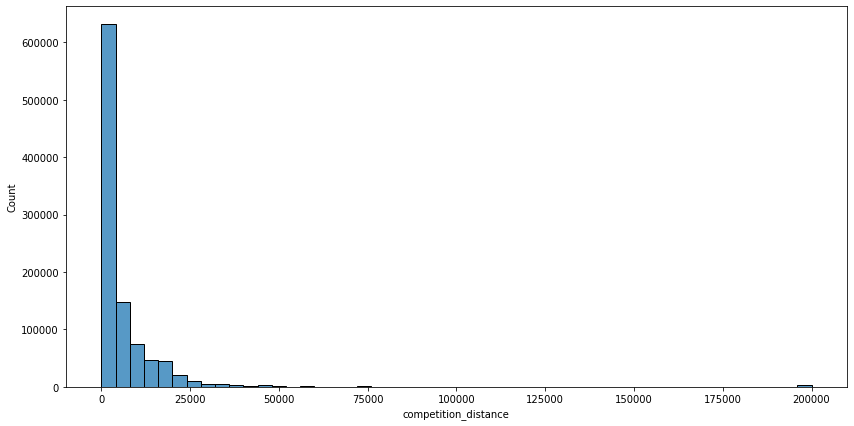

In [15]:
plt.figure(figsize=(14,7)) 
sns.histplot(df1['competition_distance'], kde=False, bins=50);

### 1.7.2 - Categorical attributes

In [16]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

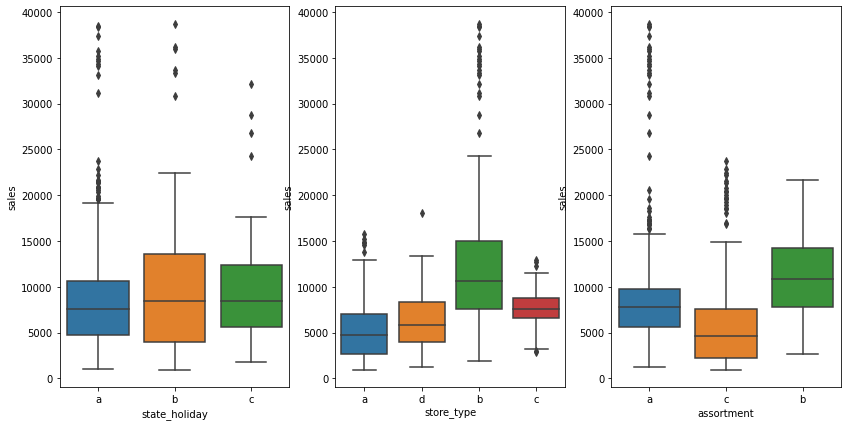

In [17]:
aux = df1[(df1['state_holiday']!='0') & (df1['sales']>0)]

plt.figure(figsize=(14,7)) 
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux);

# 2 - FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1 - Mind map hypotheses

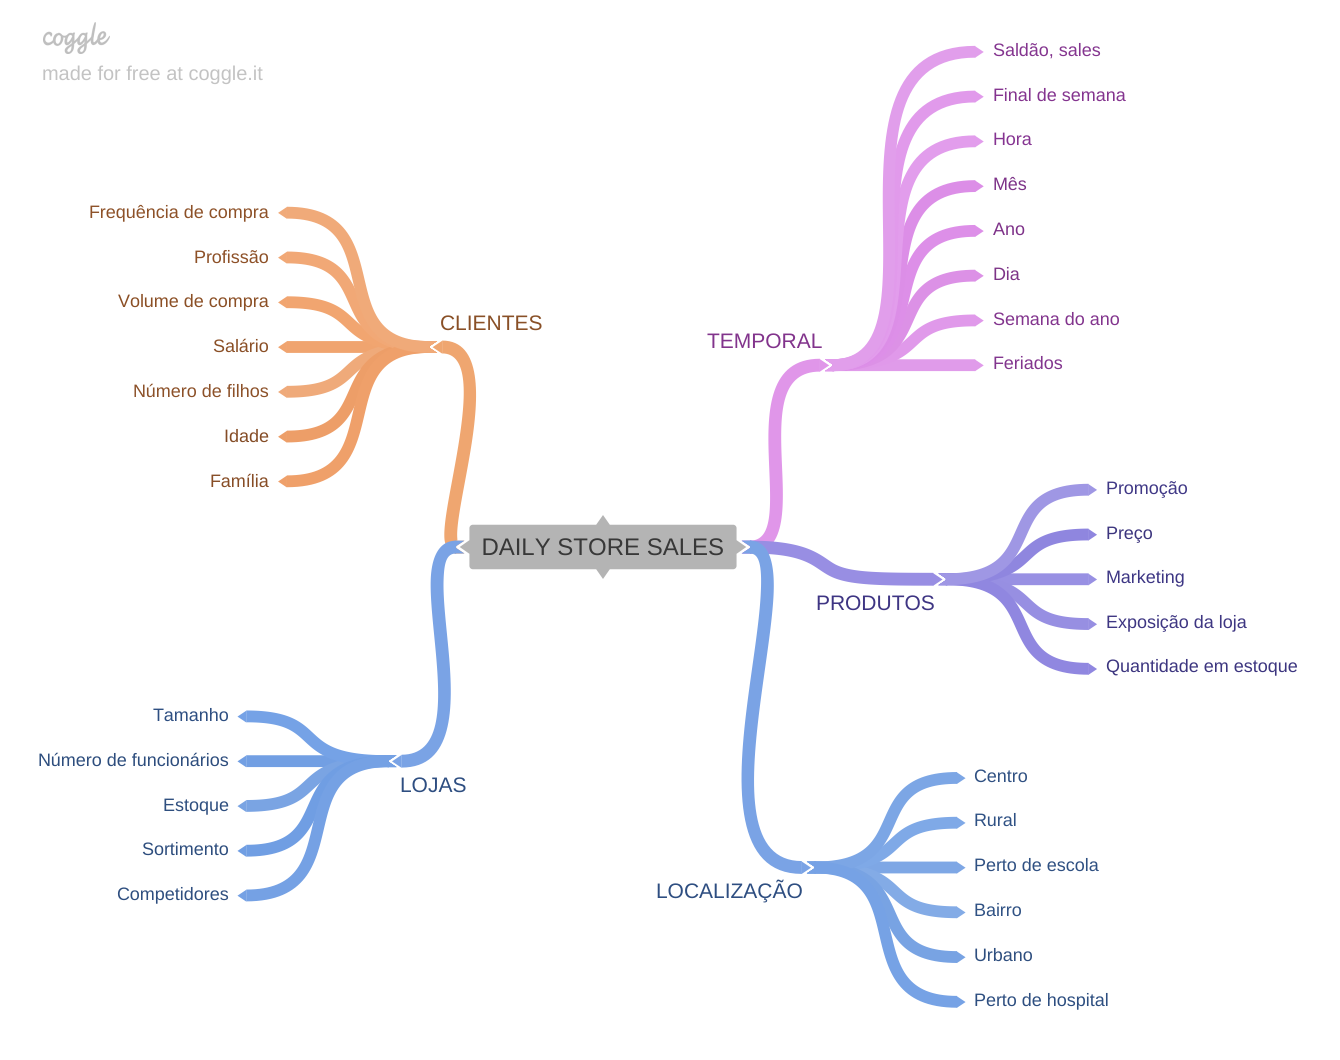

In [19]:
Image('img/DAILY_STORE_SALES.png')

## 2.2 - Creation of hypotheses

### 2.2.1 - Store hypotheses

**1.** Stores with more employees should sell more.

**2.** Stores with greater inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with greater assortment should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with longer competitors should sell more.

### 2.2.2 - Product hypotheses

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with more product exposure should sell more.

**3.** Stores with lower priced products should sell more.

**5.** Stores with more aggressive promotions (bigger discounts) should sell more.

**6.** Stores with longer active promotions should sell more.

**7.** Stores with more days of promotion should sell more.

**8.** Stores with more consecutive promotions should sell more.

### 2.2.3 - Time hypotheses

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.3 - Selected hypothses

**1.** Stores with larger assortments should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with longer active promotions should sell more.

**5.** Stores with more days of promotion should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 2.4 - Feature engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week_of_year
df2['week_of_year']= df2['date'].dt.isocalendar().week

# year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition_since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

# 3 - DATA FILTERING

In [21]:
df3 = df2.copy()

In [22]:
df3.shape

(1001599, 30)

## 3.1 - Rows filtering

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [24]:
df3.shape

(830918, 30)

## 3.2 - Columns filtering

In [25]:
df3 = df3.drop(['customers', 'open', 'promo_interval', 'month_map', 'id'], axis=1)

In [26]:
df3.shape

(830918, 25)

# 4 - EXPLORATORY DATA ANALYSIS (EDA)

In [27]:
df4 = df3.copy()

## 4.1 - Univariate analysis

### 4.1.1 - Response variable

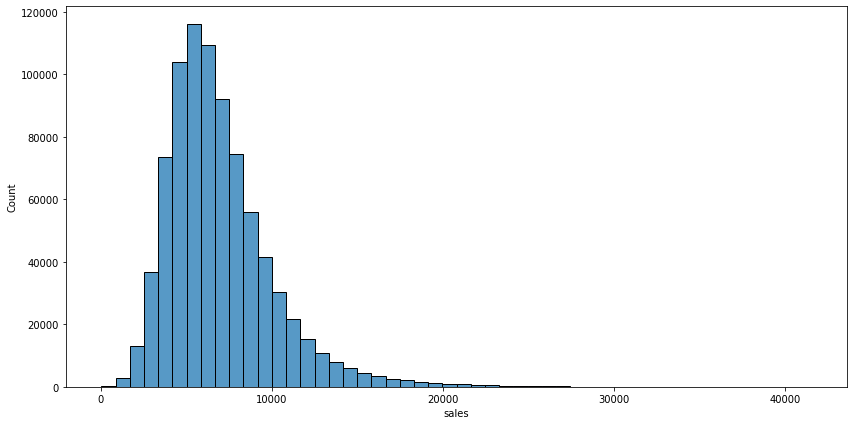

In [28]:
plt.figure(figsize=(14,7))
sns.histplot(df4['sales'], kde=False, bins=50);

### 4.1.2 - Numerical variable

In [29]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

/tmp/ipykernel_3670/3699462638.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  num_attributes.hist(ax=ax, bins=50);


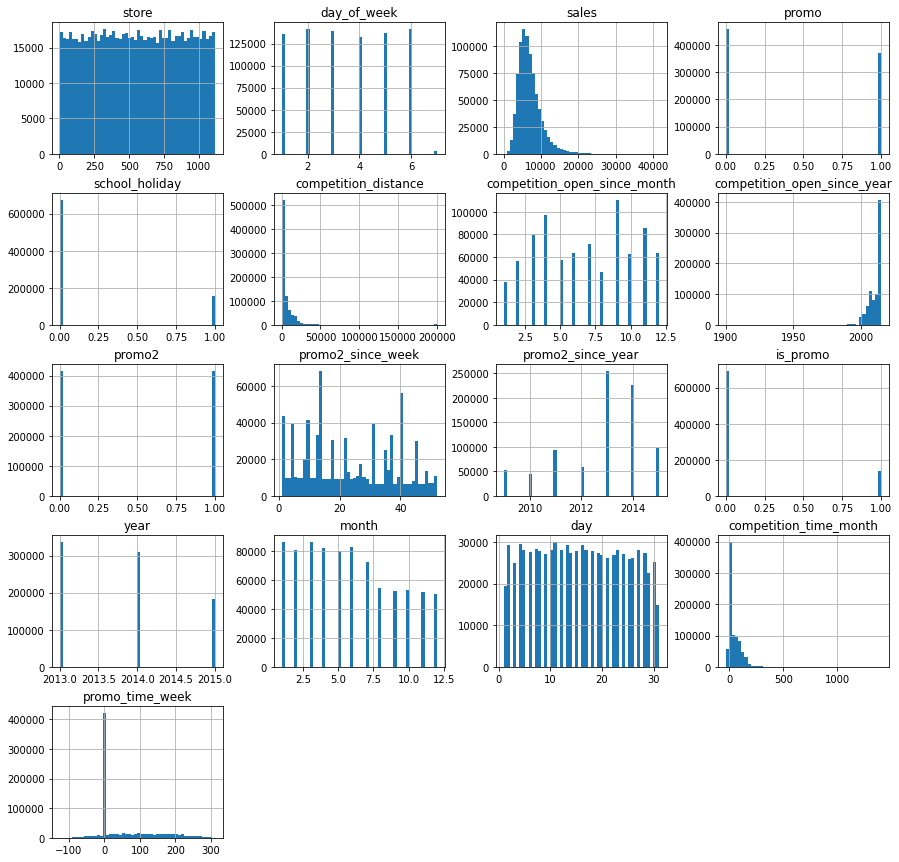

In [30]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
num_attributes.hist(ax=ax, bins=50);
#num_attributes.hist(bins=25);

### 4.1.3 - Categorical variable

In [31]:
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

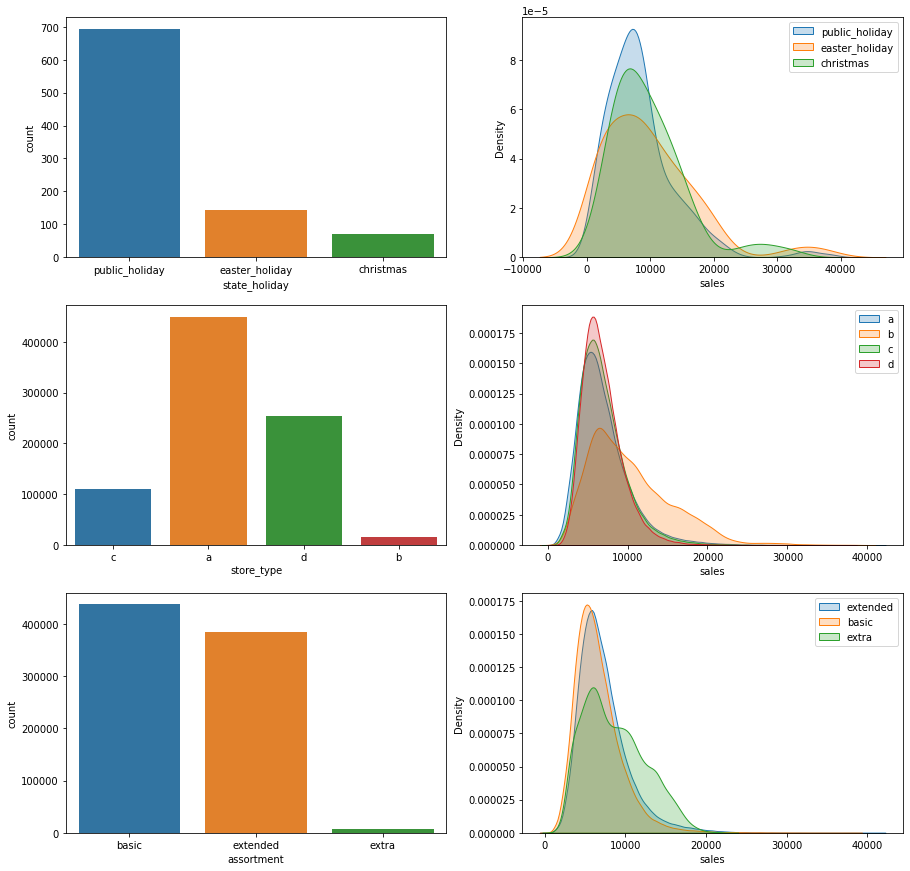

In [32]:
# state_holiday
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data=a, x='state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(data=df4[df4['state_holiday'] == 'public_holiday'], x='sales', label='public_holiday', shade=True)
sns.kdeplot(data=df4[df4['state_holiday'] == 'easter_holiday'], x='sales', label='easter_holiday', shade=True)
sns.kdeplot(data=df4[df4['state_holiday'] == 'christmas'], x='sales', label='christmas', shade=True)
plt.legend()

# store_type
plt.subplot(3,2,3)
sns.countplot(data=df4, x='store_type')

plt.subplot(3,2,4)
sns.kdeplot(data=df4[df4['store_type'] == 'a'], x='sales', label='a', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'b'], x='sales', label='b', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'c'], x='sales', label='c', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'd'], x='sales', label='d', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(data=df4, x='assortment')

plt.subplot(3,2,6)
sns.kdeplot(data=df4[df4['assortment'] == 'extended'], x='sales', label='extended', shade=True)
sns.kdeplot(data=df4[df4['assortment'] == 'basic'], x='sales', label='basic', shade=True)
sns.kdeplot(data=df4[df4['assortment'] == 'extra'], x='sales', label='extra', shade=True)
plt.legend();

## 4.2 - Bivariate analysis

**H1.** Stores with larger assortments should sell more.

**FALSE** Stores with larger assortment sell LESS.

<AxesSubplot:xlabel='year_week'>

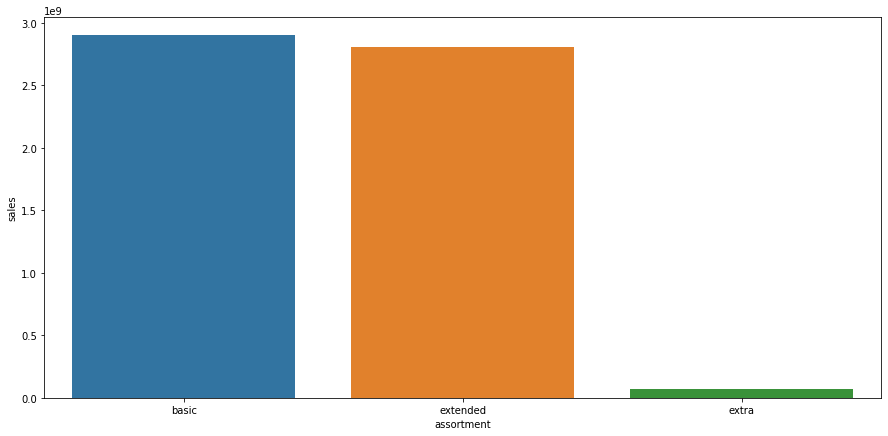

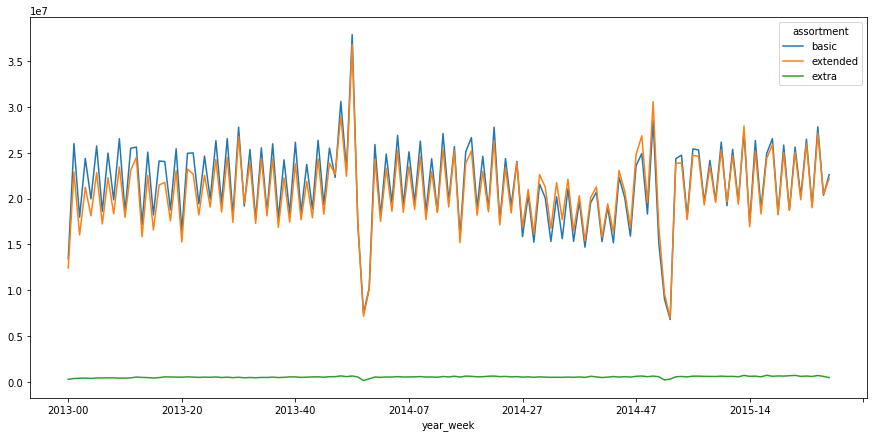

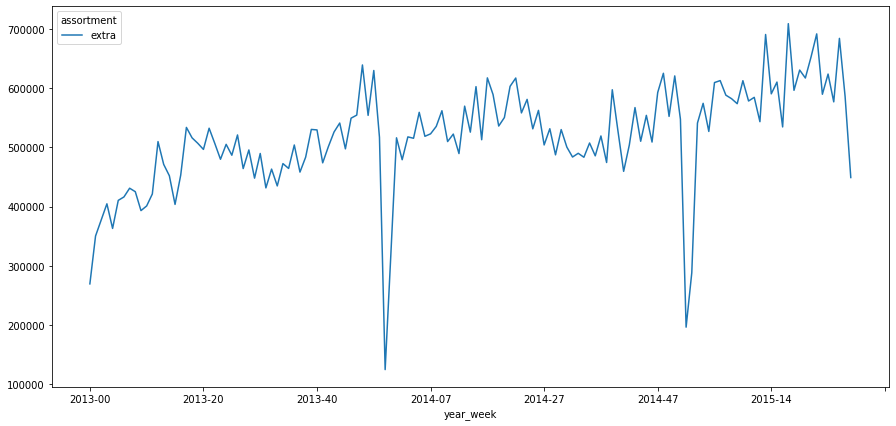

In [33]:
plt.figure(figsize=(15,7))
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(data=aux1, x='assortment', y='sales')

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(15,7))

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(15,7))

**H2.** Stores with closer competitors should sell less.

**FALSE** Store with closer competitors sell MORE.

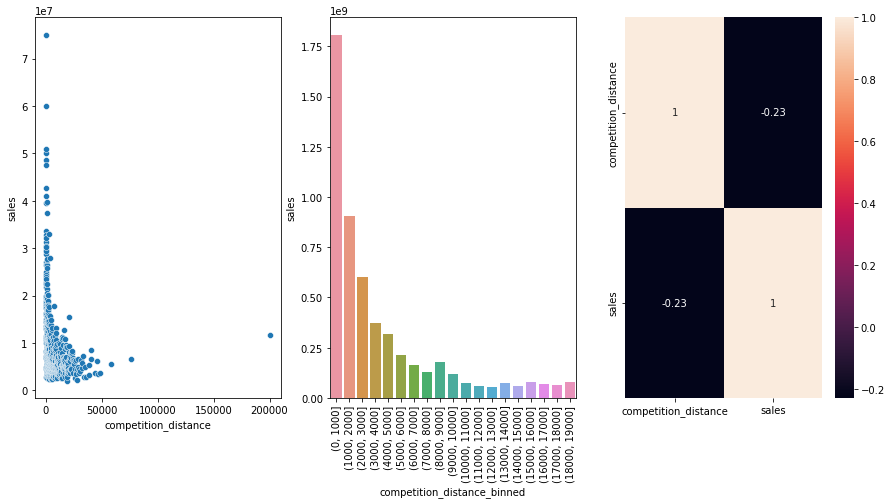

In [34]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1,3,3)
x=sns.heatmap(aux1.corr(method='pearson'), annot=True)

**H3.** Stores with longer competitors should sell more.

**FALSE** Stores with longer competitors sell LESS after a period.

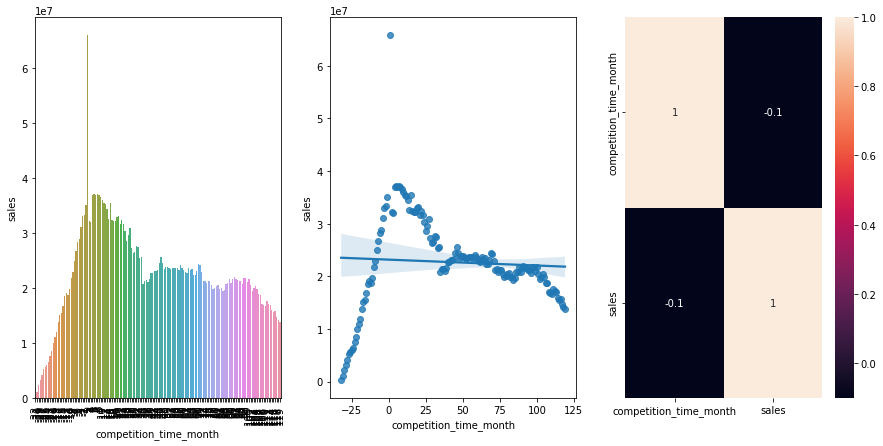

In [35]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)

**H4.** Stores with longer active promotions should sell more.

**FALSE** Stores with longer active promotions sell LESS after a period.

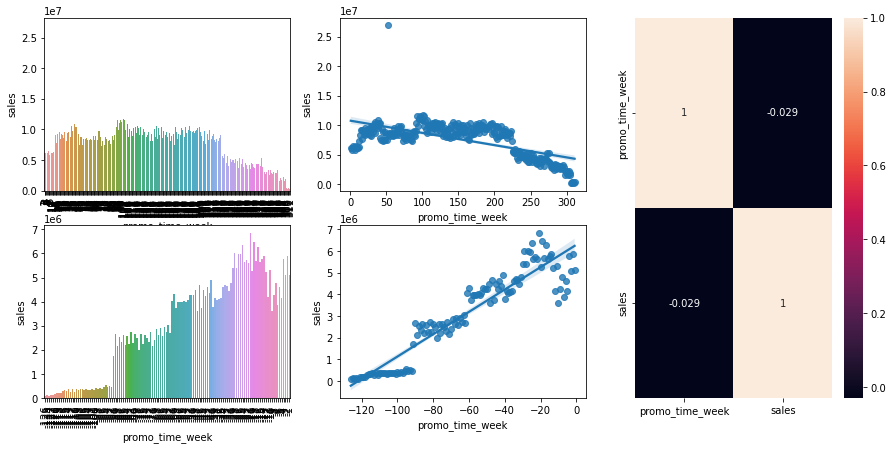

In [36]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize=(15,7))
grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # only longer promo
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # only regular promo
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

<s> **H5.** Stores with more days of promotion should sell more. <s>

**H6.** Stores with more consecutive promotions should sell more.

**FALSE** Stores with more consecutive promotions sell LESS.

In [37]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1458620310
1,0,1,1267204512
2,1,0,1605214763
3,1,1,1448760600


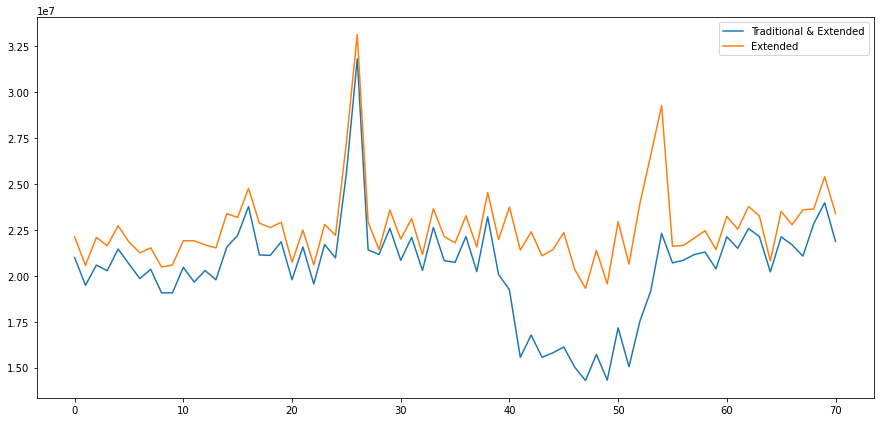

In [38]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize=(15,7))

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels=['Traditional & Extended', 'Extended']);

**H7.** Stores open during the Christmas holiday should sell more.

**FALSE** Stores open during the Christmas holiday sell LESS.

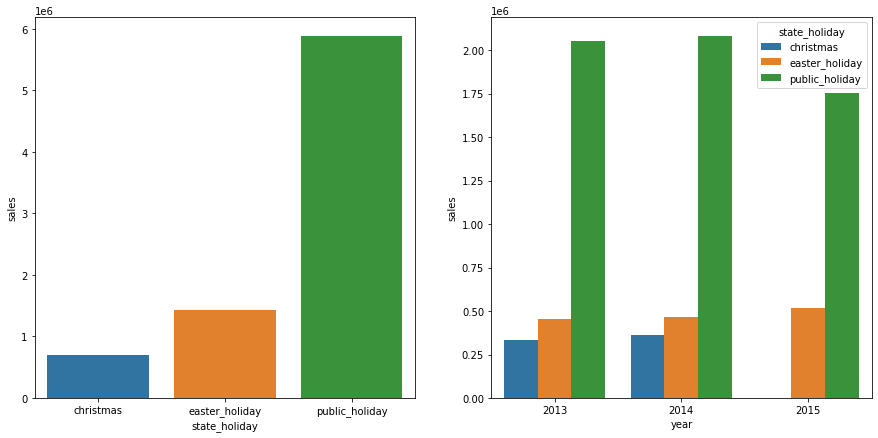

In [39]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

**H8.** Stores should sell more over the years.

**FALSE** Stores sell LESS over the years.

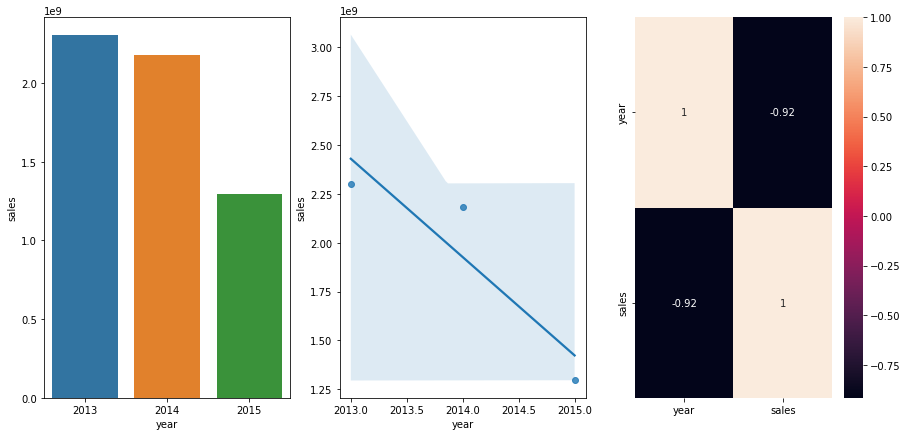

In [40]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**H9.** Stores should sell more in the second half of the year.

**FALSE** Stores sell LESS in the second half of the year.

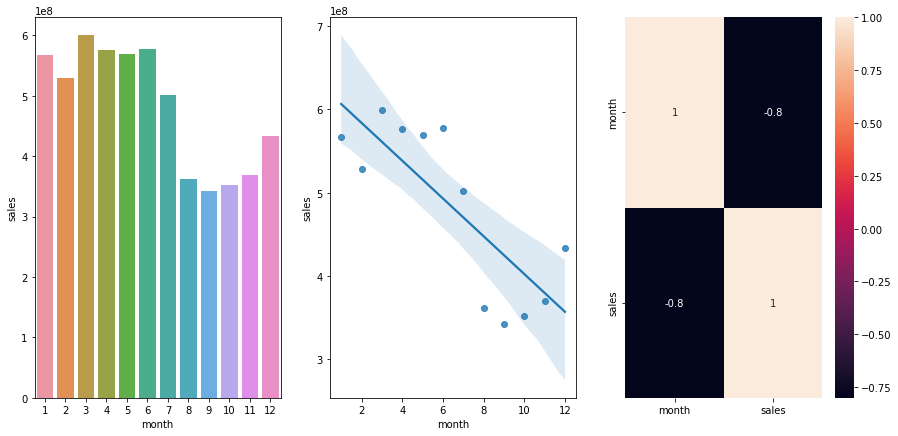

In [41]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**H10.** Stores should sell more after the 10th of each month.

**TRUE** Stores sell MORE after the 10th of each month.

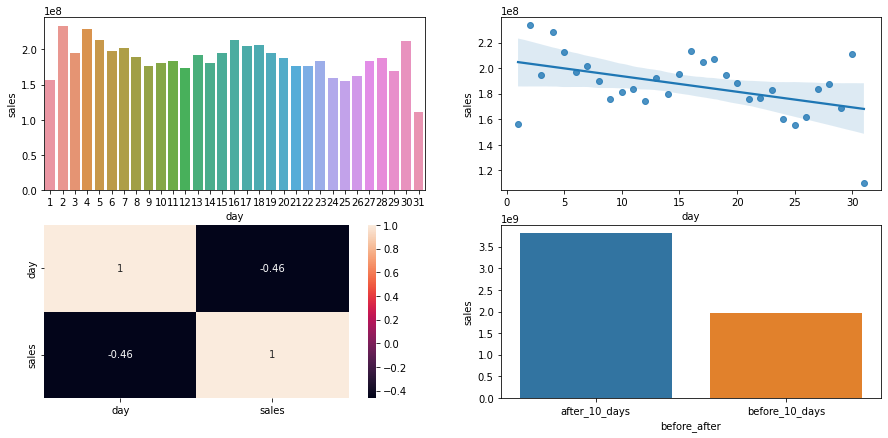

In [42]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(15,7))
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

**H11.** Stores should sell less on weekends.

**TRUE** Stores sell LESS on weekends.

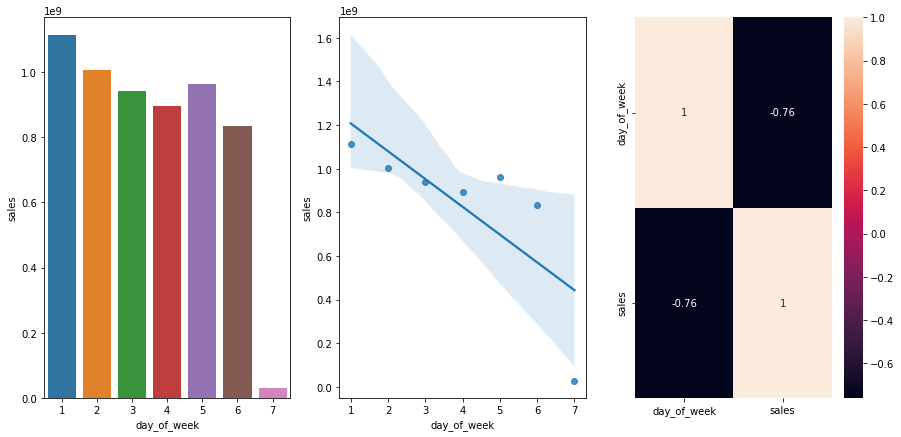

In [43]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**H12.** Stores should sell less during school holidays.

**TRUE** Stores sell LESS during school holidays.

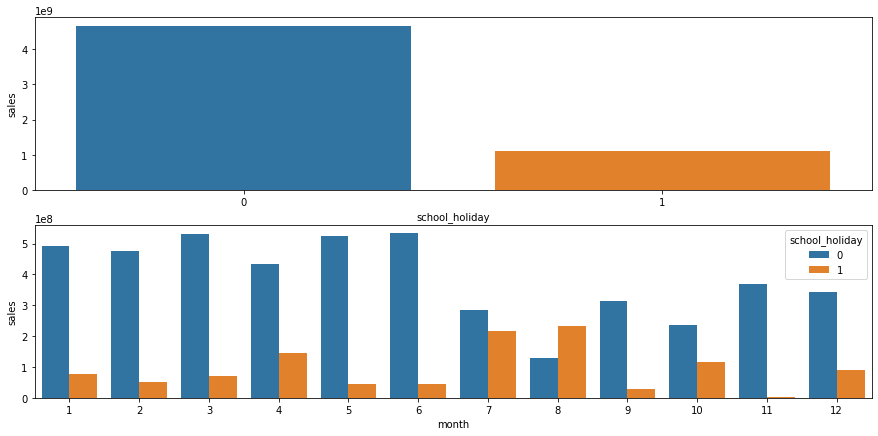

In [44]:
plt.figure(figsize=(15,7))

aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

## 4.3 - Multivariate analysis

### 4.3.1 - Numerical attributes

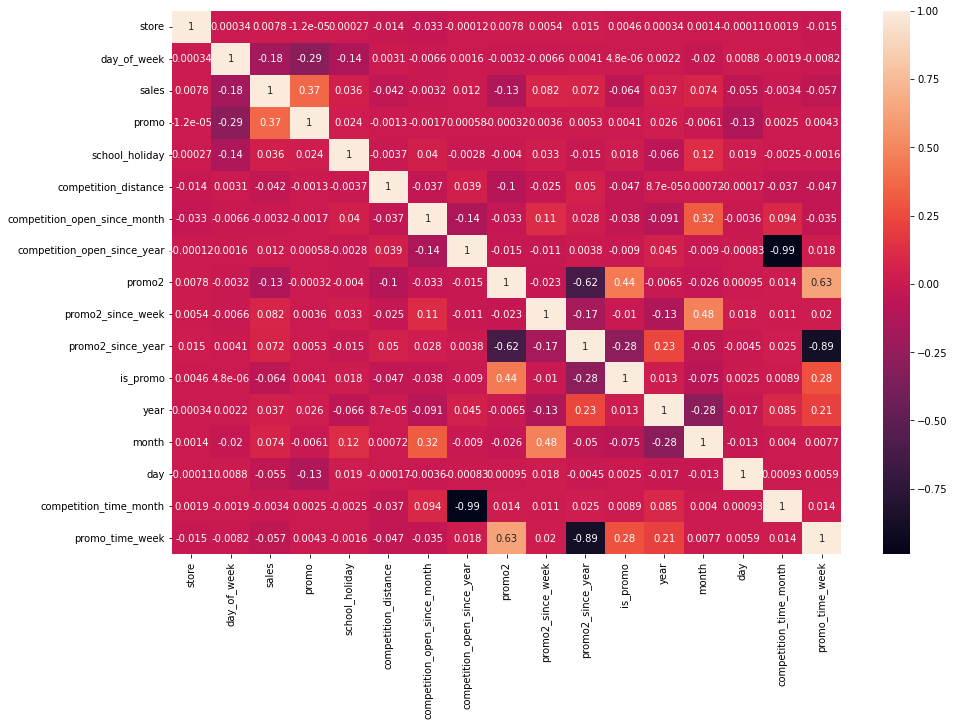

In [45]:
plt.figure(figsize=(15,10))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 - Categorical attributes

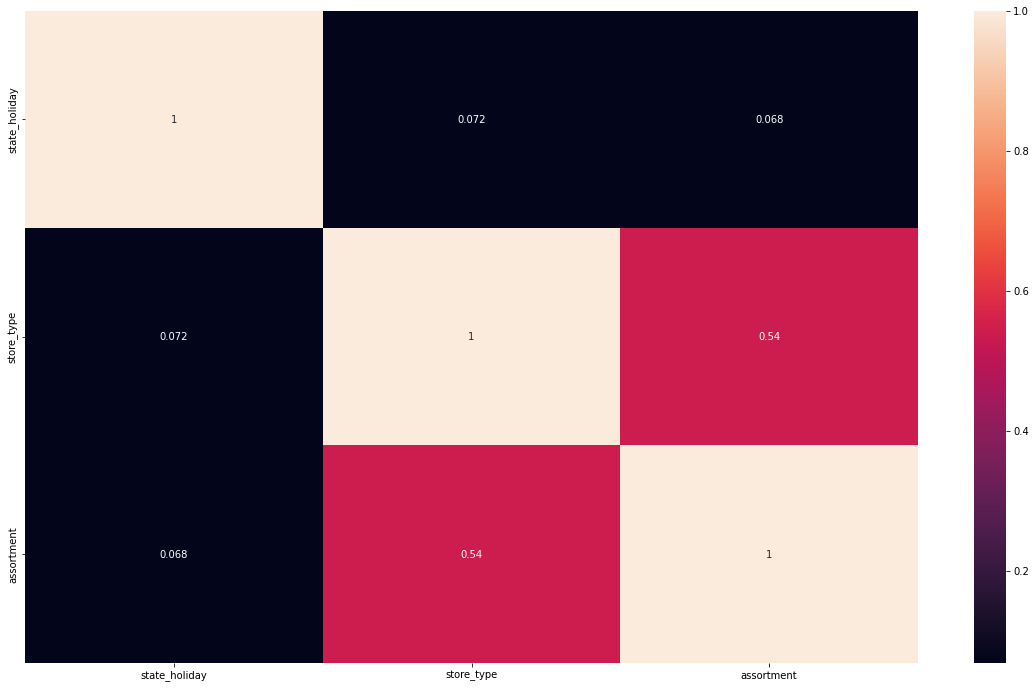

In [46]:
cat_attributes_list = cat_attributes.drop(['week_of_year', 'year_week'], axis=1).columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list


# plot
plt.figure(figsize=(20,12))
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# 5 - DATA PREPARATION

In [47]:
df5 = df4.copy()

## 5.1 - Normalization

Nothing to do.

## 5.2 - Rescalling

In [48]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
#pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
#pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
#pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
#pickle.dump(mms, open('parameter/competition_time_month_scaler.pkl', 'wb'))

## 5.3 - Transformation

### 5.3.1 - Encoding

In [49]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
#pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 - Response variable transformation

In [50]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 - Nature transformation

In [51]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))


# 6 - FEATURE SELECTION

In [52]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [53]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [54]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-17 00:00:00


## 6.2 - Boruta as feature selector

In [55]:
## training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)
#
## define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 - Best features from Boruta

In [56]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()
#
## not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 - Manual feature selection

In [57]:
cols_selected_boruta = [
    'store', 
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos'
]

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7 - MACHINE LEARNING MODELLING

In [58]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time series data preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 - Average model

In [59]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1346.198885,0.202911,1864.814994


## 7.2 - Linear regression model

In [60]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1874.551849,0.291725,2696.356777


In [61]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=True)
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 - Linear regression regularized model (Lasso)

In [62]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1905.016434,0.28804,2779.848762


In [63]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression - Lasso', lrr, verbose=True)
lrr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 - Random forest regressor

The Random Forest couldn't used due the low configurations of the computer used for this project.

In [64]:
## model
#rf = RandomForestRegressor(warm_start=True, n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)
#
## prediction
#yhat_rf = rf.predict(x_test)
#
## performance
#rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
#rf_result

In [65]:
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
#rf_result_cv

## 7.5 - XGBoost regressor

In [66]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performace
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6701.77479,0.949688,7359.94818


In [67]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,7049.23 +/- 588.53,0.95 +/- 0.0,7715.25 +/- 689.33


## 7.6 - Compare model's performance

### 7.6.1 - Single performance

In [68]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Average Model,1346.198885,0.202911,1864.814994
0,Linear Regression,1874.551849,0.291725,2696.356777
0,Linear Regression - Lasso,1905.016434,0.288040,2779.848762
0,XGBoost Regressor,6701.774790,0.949688,7359.948180


### 7.6.2 - Real performance - Cross validation

In [69]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression - Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost,7049.23 +/- 588.53,0.95 +/- 0.0,7715.25 +/- 689.33


## 8 - HYPERPARAMETER FINE TUNING

## 8.1 - Random search

In [75]:
param = {
        'n_estimators': [1500, 1700, 2500, 3000, 3500],
        'eta': [0.01, 0.03],
        'max_depth': [3, 5, 9],
        'subsample': [0.1, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.7, 0.9],
        'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 20

In [76]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = {k: rdm.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    
    # model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight']).fit(x_train, y_train)

    # performace
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2




KeyboardInterrupt



In [77]:
final_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1598.33 +/- 162.06,0.22 +/- 0.01,2309.13 +/- 210.53
0,XGBoost Regressor,1457.6 +/- 153.47,0.2 +/- 0.01,2100.9 +/- 191.44
0,XGBoost Regressor,1058.61 +/- 141.26,0.14 +/- 0.01,1536.97 +/- 199.08
0,XGBoost Regressor,839.51 +/- 130.93,0.12 +/- 0.01,1209.97 +/- 184.92
0,XGBoost Regressor,1733.99 +/- 189.48,0.24 +/- 0.01,2486.95 +/- 257.7
0,XGBoost Regressor,1192.08 +/- 125.69,0.16 +/- 0.01,1720.66 +/- 170.92
0,XGBoost Regressor,836.98 +/- 131.8,0.12 +/- 0.01,1212.49 +/- 202.38
0,XGBoost Regressor,825.37 +/- 133.26,0.11 +/- 0.01,1199.29 +/- 204.93
0,XGBoost Regressor,1047.16 +/- 116.07,0.15 +/- 0.01,1497.49 +/- 164.51
0,XGBoost Regressor,1035.93 +/- 131.57,0.14 +/- 0.01,1492.63 +/- 173.9


## 8.2 - Final model

In [78]:
param_tuned = {
    'n_estimators': 3500,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.7,
    'colsample_bytree': 0.3,
    'min_child_weight': 8
}

In [73]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performace
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,752.588162,0.112953,1098.044423


In [74]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.022960066676818807

In [79]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performace
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,625.976654,0.092364,920.148369


In [80]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.00902106698208331

# 9 - ERROR INTERPRETATION

In [82]:
df9 = X_test[cols_selected_boruta_full].copy()

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 - Business performance

In [83]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [84]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
908,909,119055.132812,109127.139915,128983.125710,9927.992898,0.729670
291,292,106735.007812,103495.888556,109974.127069,3239.119256,0.555797
875,876,203176.140625,199366.516135,206985.765115,3809.624490,0.288303
781,782,147094.140625,146176.805586,148011.475664,917.335039,0.286775
533,534,197673.687500,196130.350098,199217.024902,1543.337402,0.262496


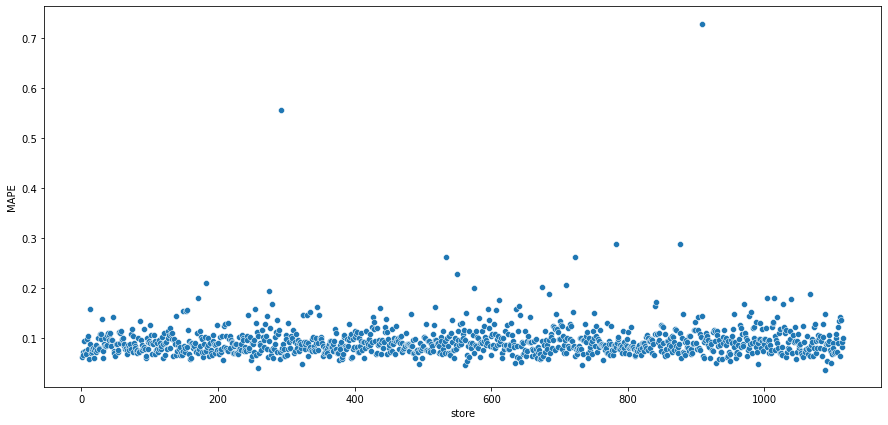

In [86]:
plt.figure(figsize=(15, 7))
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2 - Total performance

In [87]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$194,908,128.00"
1,worst_scenario,"R$194,204,513.25"
2,best_scenario,"R$195,611,766.60"


## 9.3 - Machine learning performance

In [88]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

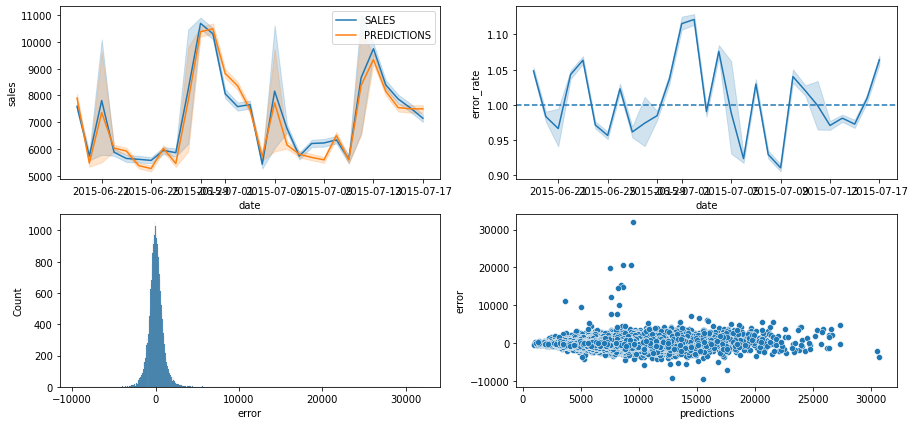

In [95]:
plt.figure(figsize=(15,7))
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.histplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(x='predictions', y='error', data=df9);